# **Tugas 4 - Graph**

**Nama : Achmad Baharuddin Akbar**

**NIM  : 210411100001**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
!pip install Sastrawi
nltk.download('punkt')

from nltk.corpus import stopwords
#stemming
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import nltk

from nltk.tokenize import sent_tokenize

import networkx as nx
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Baca file CSV
df = pd.read_csv("/content/drive/MyDrive/PPW-A/report/tugas-ppw/data_berita_detik.csv")
df.head()

,judul,tanggal,isi,kategori
0,"Menyoal Transplantasi Hati, Prosedur yang Baka...","Selasa, 08 Okt 2024 18:00 WIB",Jakarta - Politikus Demokrat Andi Arief bakal ...,Kesehatan
1,PPDS FK Unsrat-RS Kandou Disetop terkait Bully...,"Selasa, 08 Okt 2024 17:01 WIB",Jakarta - Kementerian Kesehatan RI (Kemenkes) ...,Kesehatan
2,"7 Bumbu Dapur yang Bisa Bantu BB Cepat Turun, ...","Selasa, 08 Okt 2024 16:12 WIB","Jakarta - Demi bisa menurunkan berat badan, me...",Kesehatan
3,"Pungli di PPDS FK Unsrat Disebut Puluhan Juta,...","Selasa, 08 Okt 2024 15:14 WIB",Jakarta - Kementerian Kesehatan RI memberhenti...,Kesehatan
4,Lagi! Kemenkes Bekukan PPDS FK Unsrat-RS Kando...,"Selasa, 08 Okt 2024 14:35 WIB",Jakarta - Kementerian Kesehatan RI menyetop se...,Kesehatan


In [ ]:
# mengambil satu sample berita
sample_berita = df['isi'].iloc[4]
print(sample_berita)

Jakarta - Kementerian Kesehatan RI menyetop sementara kegiatan prodi ilmu penyakit dalam Fakultas Kedokteran Universitas Sam Ratulangi (Unsrat) di RSUP Prof Dr dr R D Kandou, buntut temuan kasus bullying atau perundungan. Sedikitnya ada tiga pertimbangan di balik pemberhantian sementara FK Unsrat, termasuk pemungutan uang di luar biaya pendidikan. Perundungan dilakukan peserta PPDS (Program Pendidikan Dokter Spesialis) senior kepada junior. "Terdapat permintaan pembayaran atau pungutan liar oleh PPDS senior penyakit dalam kepada PPDS junior dan calon PPDS penyakit dalam," tutur Direktur Pelayanan Kesehatan Kemenkes RI Azhar Jaya dalam surat instruksi yang dirilis 5 Oktober. Surat tersebut telah dikonfirmasi juru bicara Kemenkes RI Mohammad Syahril. "Iya benar, sama kasusnya seperti Undip ya. Kita memberlakukan ini agar memberikan ruang perbaikan di FK terkait," katanya kepada detikcom Selasa (8/10/2024). Pihak Kemenkes RI juga disebut sudah melakukan peneguran sebelum akhirnya memutusk

In [ ]:
# Membuat list untuk menyimpan hasil
result_list = []

# Pisahkan kalimat berdasarkan titik
sentences = sample_berita.split('.')  # Pisahkan kalimat berdasarkan titik
sentences = [s.strip() for s in sentences if s.strip()]  # Hilangkan spasi berlebih dan kosong

# Looping untuk menambahkan setiap kalimat ke result_list
for i, sentence in enumerate(sentences, 1):
    result_list.append({'kalimat ke n': f"Kalimat ke {i}", 'kalimat': sentence})

# Membuat DataFrame dari hasil pemisahan
result_df = pd.DataFrame(result_list)

# Tampilkan DataFrame
result_df

,kalimat ke n,kalimat
0,Kalimat ke 1,Jakarta - Kementerian Kesehatan RI menyetop se...
1,Kalimat ke 2,Sedikitnya ada tiga pertimbangan di balik pemb...
2,Kalimat ke 3,Perundungan dilakukan peserta PPDS (Program Pe...
3,Kalimat ke 4,"""Terdapat permintaan pembayaran atau pungutan ..."
4,Kalimat ke 5,Surat tersebut telah dikonfirmasi juru bicara ...
5,Kalimat ke 6,"""Iya benar, sama kasusnya seperti Undip ya"
6,Kalimat ke 7,Kita memberlakukan ini agar memberikan ruang p...
7,Kalimat ke 8,Pihak Kemenkes RI juga disebut sudah melakukan...
8,Kalimat ke 9,"Namun, perundungan dilaporkan masih terus berl..."
9,Kalimat ke 10,"""Masih terjadinya kejadian perundungan walaupu..."


In [ ]:
# Download stopwords untuk bahasa Indonesia
nltk.download('stopwords')
stop_words = stopwords.words('indonesian')

# Fungsi preprocessing yang disesuaikan
def remove_url(data_berita):
    url = re.compile(r'https?://\S+|www\.S+')
    return url.sub(r'', data_berita)

def remove_html(data_berita):
    html = re.compile(r'<.#?>')
    return html.sub(r'', data_berita)

def remove_emoji(data_berita):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticon
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', data_berita)

def remove_numbers(data_berita):
    data_berita = re.sub(r'\d+', '', data_berita)
    return data_berita

def remove_symbols(data_berita):
    data_berita = re.sub(r'[^a-zA-Z0-9\s]', '', data_berita)
    return data_berita

def case_folding(text):
    if isinstance(text, str):
        return text.lower()
    return text

def tokenize(text):
    return text.split()

def remove_stopwords(text):
    return [word for word in text if word not in stop_words]

# Inisialisasi stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming(text):
    return [stemmer.stem(word) for word in text]

# Looping setiap kalimat di dataframe 'result_df'
result_df['clean'] = result_df['kalimat'].apply(remove_url)
result_df['clean'] = result_df['clean'].apply(remove_html)
result_df['clean'] = result_df['clean'].apply(remove_emoji)
result_df['clean'] = result_df['clean'].apply(remove_symbols)
result_df['clean'] = result_df['clean'].apply(remove_numbers)
result_df['clean'] = result_df['clean'].apply(case_folding)
result_df['tokenize'] = result_df['clean'].apply(tokenize)
result_df['stopword removal'] = result_df['tokenize'].apply(remove_stopwords)
result_df['stemming'] = result_df['stopword removal'].apply(stemming)

# Gabungkan kata setelah stemming
result_df['final'] = result_df['stemming'].apply(lambda x: ' '.join(x))

# Tampilkan hasil dataframe
result_df[['kalimat ke n', 'final']]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,kalimat ke n,final
0,Kalimat ke 1,jakarta menteri sehat ri setop giat prodi ilmu...
1,Kalimat ke 2,timbang pemberhantian fk unsrat mungut uang bi...
2,Kalimat ke 3,rundung serta ppds program didik dokter spesia...
3,Kalimat ke 4,minta bayar pungut liar ppds senior sakit ppds...
4,Kalimat ke 5,surat konfirmasi juru bicara kemenkes ri moham...
5,Kalimat ke 6,iya kasus undip ya
6,Kalimat ke 7,laku ruang baik fk kait detikcom selasa
7,Kalimat ke 8,kemenkes ri tegur putus henti prodi ilmu sakit...
8,Kalimat ke 9,rundung lapor lanjut
9,Kalimat ke 10,jadi rundung ingat menteri sehat


In [ ]:
# Gabungkan semua kalimat hasil stemming menjadi dokumen untuk tiap kalimat
documents = result_df['final'].tolist()

# Inisialisasi TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Terapkan TF-IDF ke dokumen (kalimat yang sudah dipreproses)
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

# Mendapatkan nama-nama fitur (kata-kata)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Mengubah hasil TF-IDF menjadi dataframe
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Tambahkan kolom 'no' dan 'kalimat ke n' untuk identifikasi
tfidf_df.insert(0, 'kalimat ke n', result_df['kalimat ke n'])

# Tampilkan dataframe dengan skor TF-IDF
tfidf_df

,kalimat ke n,ancam,azhar,baik,bayar,beku,bentuk,biaya,bicara,bullying,...,temu,timbang,tutup,uang,undip,universitas,unsrat,upaya,verbal,ya
0,Kalimat ke 1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.203840,...,0.233444,0.000000,0.000000,0.000000,0.0,0.203840,0.141974,0.000000,0.000000,0.0
1,Kalimat ke 2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.406003,0.000000,0.000000,...,0.000000,0.354515,0.000000,0.406003,0.0,0.000000,0.246920,0.000000,0.000000,0.0
2,Kalimat ke 3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
3,Kalimat ke 4,0.000000,0.172550,0.000000,0.220313,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
4,Kalimat ke 5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.400591,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
5,Kalimat ke 6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.5,0.000000,0.000000,0.000000,0.000000,0.5
6,Kalimat ke 7,0.000000,0.000000,0.365843,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
7,Kalimat ke 8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.257702,0.000000,0.000000,0.0
8,Kalimat ke 9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
9,Kalimat ke 10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0


In [ ]:
# Menghitung cosine similarity antar kalimat berdasarkan TF-IDF
cosine_sim = cosine_similarity(tfidf_matrix)

# Membuat dataframe untuk menyimpan hasil cosine similarity
cosine_sim_df = pd.DataFrame(cosine_sim, index=result_df['kalimat ke n'], columns=result_df['kalimat ke n'])

# Tampilkan matriks cosine similarity
cosine_sim_df

kalimat ke n,Kalimat ke 1,Kalimat ke 2,Kalimat ke 3,Kalimat ke 4,Kalimat ke 5,Kalimat ke 6,Kalimat ke 7,Kalimat ke 8,Kalimat ke 9,Kalimat ke 10,Kalimat ke 11,Kalimat ke 12,Kalimat ke 13,Kalimat ke 14,Kalimat ke 15,Kalimat ke 16,Kalimat ke 17
kalimat ke n,,,,,,,,,,,,,,,,,
Kalimat ke 1,1.000000,0.035056,0.079469,0.094888,0.034589,0.0,0.000000,0.226814,0.051888,0.217702,0.022150,0.100012,0.068547,0.205194,0.495692,0.186496,0.0
Kalimat ke 2,0.035056,1.000000,0.102173,0.000000,0.000000,0.0,0.054573,0.118824,0.000000,0.000000,0.000000,0.051514,0.088130,0.263700,0.044365,0.097702,0.0
Kalimat ke 3,0.079469,0.102173,1.000000,0.248891,0.000000,0.0,0.000000,0.000000,0.091189,0.072343,0.175108,0.052053,0.372460,0.000000,0.082521,0.000000,0.0
Kalimat ke 4,0.094888,0.000000,0.248891,1.000000,0.108692,0.0,0.000000,0.155191,0.000000,0.074280,0.179425,0.053447,0.248272,0.078848,0.066431,0.160676,0.0
Kalimat ke 5,0.034589,0.000000,0.000000,0.108692,1.000000,0.0,0.000000,0.135916,0.000000,0.000000,0.000000,0.000000,0.061075,0.143368,0.027305,0.171889,0.0
Kalimat ke 6,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
Kalimat ke 7,0.000000,0.054573,0.000000,0.000000,0.000000,0.0,1.000000,0.056956,0.000000,0.000000,0.000000,0.154802,0.000000,0.060079,0.112463,0.046832,0.0
Kalimat ke 8,0.226814,0.118824,0.000000,0.155191,0.135916,0.0,0.056956,1.000000,0.000000,0.000000,0.000000,0.053763,0.000000,0.426865,0.109303,0.562047,0.0
Kalimat ke 9,0.051888,0.000000,0.091189,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.122170,0.065738,0.296823,0.078656,0.000000,0.000000,0.000000,0.0


In [ ]:
from sklearn.metrics import jaccard_score

# Fungsi untuk menghitung Jaccard similarity antar vektor
def calculate_jaccard_similarity(tfidf_matrix):
    # Inisialisasi matriks untuk menyimpan hasil Jaccard similarity
    num_sentences = tfidf_matrix.shape[0]
    jaccard_similarity_matrix = np.zeros((num_sentences, num_sentences))

    # Looping untuk menghitung Jaccard similarity antara setiap pasangan kalimat
    for i in range(num_sentences):
        for j in range(num_sentences):
            # Hitung Jaccard similarity berdasarkan vektor biner
            jaccard_similarity_matrix[i, j] = jaccard_score(tfidf_matrix[i].toarray()[0] > 0,
                                                            tfidf_matrix[j].toarray()[0] > 0)
    return jaccard_similarity_matrix

# Hitung Jaccard similarity matriks dari TF-IDF
jaccard_similarity = calculate_jaccard_similarity(tfidf_matrix)

# Membuat DataFrame dari matriks Jaccard similarity
jaccard_df = pd.DataFrame(jaccard_similarity,
                          index=result_df['kalimat ke n'],
                          columns=result_df['kalimat ke n'])

# Tampilkan DataFrame Jaccard similarity
jaccard_df

kalimat ke n,Kalimat ke 1,Kalimat ke 2,Kalimat ke 3,Kalimat ke 4,Kalimat ke 5,Kalimat ke 6,Kalimat ke 7,Kalimat ke 8,Kalimat ke 9,Kalimat ke 10,Kalimat ke 11,Kalimat ke 12,Kalimat ke 13,Kalimat ke 14,Kalimat ke 15,Kalimat ke 16,Kalimat ke 17
kalimat ke n,,,,,,,,,,,,,,,,,
Kalimat ke 1,1.000000,0.033333,0.066667,0.075000,0.033333,0.0,0.000000,0.178571,0.040000,0.120000,0.030303,0.066667,0.060606,0.142857,0.279070,0.161290,0.0
Kalimat ke 2,0.033333,1.000000,0.062500,0.000000,0.000000,0.0,0.071429,0.125000,0.000000,0.000000,0.000000,0.062500,0.052632,0.214286,0.052632,0.105263,0.0
Kalimat ke 3,0.066667,0.062500,1.000000,0.115385,0.000000,0.0,0.000000,0.000000,0.090909,0.076923,0.176471,0.058824,0.312500,0.000000,0.051282,0.000000,0.0
Kalimat ke 4,0.075000,0.000000,0.115385,1.000000,0.120000,0.0,0.000000,0.111111,0.000000,0.041667,0.107143,0.035714,0.142857,0.074074,0.061224,0.137931,0.0
Kalimat ke 5,0.033333,0.000000,0.000000,0.120000,1.000000,0.0,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.052632,0.133333,0.025641,0.166667,0.0
Kalimat ke 6,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
Kalimat ke 7,0.000000,0.071429,0.000000,0.000000,0.000000,0.0,1.000000,0.062500,0.000000,0.000000,0.000000,0.142857,0.000000,0.066667,0.083333,0.052632,0.0
Kalimat ke 8,0.178571,0.125000,0.000000,0.111111,0.125000,0.0,0.062500,1.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.357143,0.105263,0.533333,0.0
Kalimat ke 9,0.040000,0.000000,0.090909,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.142857,0.076923,0.200000,0.071429,0.000000,0.000000,0.000000,0.0


In [ ]:
# Tetapkan ambang batas (threshold) 0.7
threshold = 0.005

# Buat matriks adjacency: jika cosine similarity >= 0.6, maka 1; jika tidak, maka 0
adjacency_matrix = np.where(cosine_sim >= threshold, 1, 0)

# Buat dataframe untuk menampilkan matriks adjacency
adjacency_df = pd.DataFrame(adjacency_matrix, index=result_df['kalimat ke n'], columns=result_df['kalimat ke n'])

# Tampilkan matriks adjacency
adjacency_df

kalimat ke n,Kalimat ke 1,Kalimat ke 2,Kalimat ke 3,Kalimat ke 4,Kalimat ke 5,Kalimat ke 6,Kalimat ke 7,Kalimat ke 8,Kalimat ke 9,Kalimat ke 10,Kalimat ke 11,Kalimat ke 12,Kalimat ke 13,Kalimat ke 14,Kalimat ke 15,Kalimat ke 16,Kalimat ke 17
kalimat ke n,,,,,,,,,,,,,,,,,
Kalimat ke 1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,0
Kalimat ke 2,1,1,1,0,0,0,1,1,0,0,0,1,1,1,1,1,0
Kalimat ke 3,1,1,1,1,0,0,0,0,1,1,1,1,1,0,1,0,0
Kalimat ke 4,1,0,1,1,1,0,0,1,0,1,1,1,1,1,1,1,0
Kalimat ke 5,1,0,0,1,1,0,0,1,0,0,0,0,1,1,1,1,0
Kalimat ke 6,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
Kalimat ke 7,0,1,0,0,0,0,1,1,0,0,0,1,0,1,1,1,0
Kalimat ke 8,1,1,0,1,1,0,1,1,0,0,0,1,0,1,1,1,0
Kalimat ke 9,1,0,1,0,0,0,0,0,1,1,1,1,1,0,0,0,0


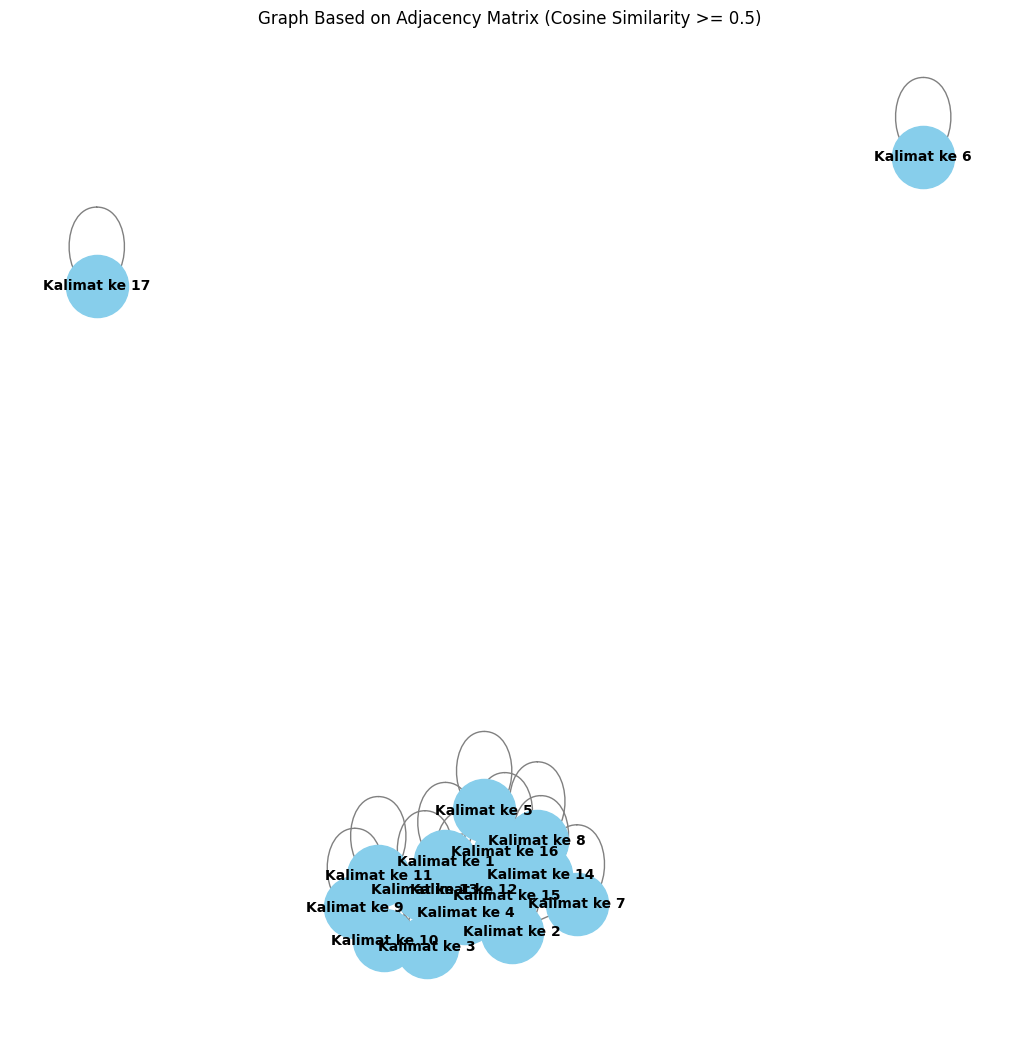

In [ ]:
# Buat graf dari matriks adjacency
G = nx.from_numpy_array(adjacency_matrix)

# Atur label node agar sesuai dengan 'kalimat ke n'
mapping = {i: f"Kalimat ke {i+1}" for i in range(len(result_df))}
G = nx.relabel_nodes(G, mapping)

# Menggambar graf
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)  # Atur layout graf
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=10, font_color='black', edge_color='gray', linewidths=1, font_weight='bold')

# Tampilkan graf
plt.title("Graph Based on Adjacency Matrix (Cosine Similarity >= 0.5)")
plt.show()

In [ ]:
# Menghitung betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Menghitung degree centrality
degree_centrality = nx.degree_centrality(G)

# Menghitung closeness centrality
closeness_centrality = nx.closeness_centrality(G)

# Buat dataframe untuk menampilkan hasil centrality
centrality_df = pd.DataFrame({
    'Kalimat': list(betweenness_centrality.keys()),
    'Betweenness Centrality': list(betweenness_centrality.values()),
    'Degree Centrality': list(degree_centrality.values()),
    'Closeness Centrality': list(closeness_centrality.values())
})

# Tampilkan dataframe centrality
centrality_df

,Kalimat,Betweenness Centrality,Degree Centrality,Closeness Centrality
0,Kalimat ke 1,0.036181,0.7500,0.680556
1,Kalimat ke 2,0.019236,0.5625,0.583333
2,Kalimat ke 3,0.021954,0.6875,0.644737
3,Kalimat ke 4,0.054792,0.8125,0.720588
4,Kalimat ke 5,0.002778,0.4375,0.532609
5,Kalimat ke 6,0.000000,0.1250,0.000000
6,Kalimat ke 7,0.001190,0.4375,0.532609
7,Kalimat ke 8,0.023968,0.6875,0.644737
8,Kalimat ke 9,0.002431,0.5000,0.556818
9,Kalimat ke 10,0.003819,0.5625,0.583333


# Pengujian

Masukkan isi berita: Jakarta - Kementerian Kesehatan RI menyetop sementara kegiatan prodi ilmu penyakit dalam Fakultas Kedokteran Universitas Sam Ratulangi (Unsrat) di RSUP Prof Dr dr R D Kandou, buntut temuan kasus bullying atau perundungan. Sedikitnya ada tiga pertimbangan di balik pemberhantian sementara FK Unsrat, termasuk pemungutan uang di luar biaya pendidikan. Perundungan dilakukan peserta PPDS (Program Pendidikan Dokter Spesialis) senior kepada junior. "Terdapat permintaan pembayaran atau pungutan liar oleh PPDS senior penyakit dalam kepada PPDS junior dan calon PPDS penyakit dalam," tutur Direktur Pelayanan Kesehatan Kemenkes RI Azhar Jaya dalam surat instruksi yang dirilis 5 Oktober. Surat tersebut telah dikonfirmasi juru bicara Kemenkes RI Mohammad Syahril. "Iya benar, sama kasusnya seperti Undip ya. Kita memberlakukan ini agar memberikan ruang perbaikan di FK terkait," katanya kepada detikcom Selasa (8/10/2024). Pihak Kemenkes RI juga disebut sudah melakukan peneguran sebe

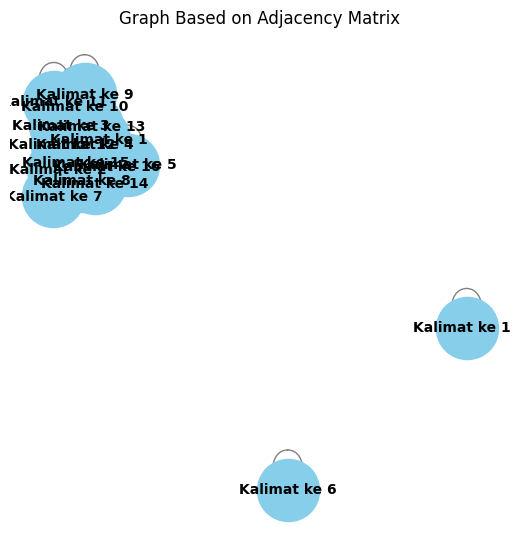


Nilai Centrality:
          Kalimat  Betweenness Centrality  Degree Centrality  \
0    Kalimat ke 1                0.036181             0.7500   
1    Kalimat ke 2                0.019236             0.5625   
2    Kalimat ke 3                0.021954             0.6875   
3    Kalimat ke 4                0.054792             0.8125   
4    Kalimat ke 5                0.002778             0.4375   
5    Kalimat ke 6                0.000000             0.1250   
6    Kalimat ke 7                0.001190             0.4375   
7    Kalimat ke 8                0.023968             0.6875   
8    Kalimat ke 9                0.002431             0.5000   
9   Kalimat ke 10                0.003819             0.5625   
10  Kalimat ke 11                0.002431             0.5000   
11  Kalimat ke 12                0.078413             0.8125   
12  Kalimat ke 13                0.059940             0.7500   
13  Kalimat ke 14                0.023968             0.6875   
14  Kalimat ke 15    

In [ ]:
# Fungsi untuk memisahkan dan memproses berita
def process_news_input(user_input):
    # Memisahkan kalimat
    result_list = []
    sentences = user_input.split('.')  # Pisahkan kalimat berdasarkan titik
    sentences = [s.strip() for s in sentences if s.strip()]  # Hilangkan spasi berlebih dan kosong
    for i, sentence in enumerate(sentences, 1):
        result_list.append({'kalimat ke n': f"Kalimat ke {i}", 'kalimat': sentence})

    result_df = pd.DataFrame(result_list)

    # Fungsi preprocessing yang disesuaikan
    def remove_url(data_berita):
        url = re.compile(r'https?://\S+|www\.S+')
        return url.sub(r'', data_berita)

    def remove_html(data_berita):
        html = re.compile(r'<.#?>')
        return html.sub(r'', data_berita)

    def remove_emoji(data_berita):
        emoji_pattern = re.compile("["u"\U0001F600-\U0001F64F"
                                   u"\U0001F300-\U0001F5FF"
                                   u"\U0001F680-\U0001F6FF"
                                   u"\U0001F1E0-\U0001F1FF""]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', data_berita)

    def remove_numbers(data_berita):
        data_berita = re.sub(r'\d+', '', data_berita)
        return data_berita

    def remove_symbols(data_berita):
        data_berita = re.sub(r'[^a-zA-Z0-9\s]', '', data_berita)
        return data_berita

    def case_folding(text):
        if isinstance(text, str):
            return text.lower()
        return text

    def tokenize(text):
        return text.split()

    def remove_stopwords(text):
        return [word for word in text if word not in stop_words]

    # Inisialisasi stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    def stemming(text):
        return [stemmer.stem(word) for word in text]

    # Looping setiap kalimat di dataframe 'result_df'
    result_df['clean'] = result_df['kalimat'].apply(remove_url)
    result_df['clean'] = result_df['clean'].apply(remove_html)
    result_df['clean'] = result_df['clean'].apply(remove_emoji)
    result_df['clean'] = result_df['clean'].apply(remove_symbols)
    result_df['clean'] = result_df['clean'].apply(remove_numbers)
    result_df['clean'] = result_df['clean'].apply(case_folding)
    result_df['tokenize'] = result_df['clean'].apply(tokenize)
    result_df['stopword removal'] = result_df['tokenize'].apply(remove_stopwords)
    result_df['stemming'] = result_df['stopword removal'].apply(stemming)

    # Gabungkan kata setelah stemming
    result_df['final'] = result_df['stemming'].apply(lambda x: ' '.join(x))

    # TF-IDF
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(result_df['final'])

    # Cosine similarity
    cosine_sim = cosine_similarity(tfidf_matrix)

    # Matriks adjacency
    threshold = 0.05
    adjacency_matrix = np.where(cosine_sim >= threshold, 1, 0)

    # Buat graf dari matriks adjacency
    G = nx.from_numpy_array(adjacency_matrix)

    # Atur label node
    mapping = {i: f"Kalimat ke {i+1}" for i in range(len(result_df))}
    G = nx.relabel_nodes(G, mapping)

    # Hitung centrality
    betweenness_centrality = nx.betweenness_centrality(G)
    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)

    # Buat dataframe untuk centrality
    centrality_df = pd.DataFrame({
        'Kalimat': list(betweenness_centrality.keys()),
        'Betweenness Centrality': list(betweenness_centrality.values()),
        'Degree Centrality': list(degree_centrality.values()),
        'Closeness Centrality': list(closeness_centrality.values())
    })

    return result_df[['kalimat ke n', 'kalimat', 'final']], cosine_sim, adjacency_matrix, G, centrality_df

# Input dari pengguna
user_input = input("Masukkan isi berita: ")

# Proses berita dan ambil hasil
result_df, cosine_sim, adjacency_matrix, G, centrality_df = process_news_input(user_input)

# Pilih jenis centrality untuk dihitung
print("\nPilih jenis centrality yang ingin dihitung:")
print("1. Betweenness Centrality")
print("2. Degree Centrality")
print("3. Closeness Centrality")
choice = int(input("Masukkan pilihan (1/2/3): "))

# Ambil centrality sesuai pilihan
if choice == 1:
    centrality_values = centrality_df[['Kalimat', 'Betweenness Centrality']]
    centrality_name = 'Betweenness Centrality'
elif choice == 2:
    centrality_values = centrality_df[['Kalimat', 'Degree Centrality']]
    centrality_name = 'Degree Centrality'
elif choice == 3:
    centrality_values = centrality_df[['Kalimat', 'Closeness Centrality']]
    centrality_name = 'Closeness Centrality'
else:
    print("Pilihan tidak valid.")
    exit()

# Ringkasan: 3 kalimat dengan centrality tertinggi
top_sentences = centrality_values.nlargest(3, centrality_name)

# Tampilkan hasil
print("\nHasil Pemisahan Kalimat:")
print(result_df)
print("\nCosine Similarity Matrix:")
print(cosine_sim)
print("\nAdjacency Matrix:")
print(adjacency_matrix)
print("\nGraph:")
plt.figure(figsize=(5, 5))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=10, font_color='black', edge_color='gray', linewidths=1, font_weight='bold')
plt.title("Graph Based on Adjacency Matrix")
plt.show()
print("\nNilai Centrality:")
print(centrality_df)
print(f"\nRingkasan (3 Kalimat Teratas Berdasarkan {centrality_name}):")
print(top_sentences)